In [1]:
from pyqumo.algorithms.networks.mapph1n_tandem import solve_iterative, reduce_map
from pyqumo.random import PhaseType, Exponential
from pyqumo.arrivals import MarkovArrival
from pyqumo.cqumo.sim import simulate_tandem

import matplotlib
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
import time
import locale
import os

import numpy as np

## Настройка графиков

In [2]:
def setup_matplotlib() -> None:
    """
    Настроить параметры matplotlib и локали.
    """
    matplotlib.rcParams.update({
        'image.cmap': 'viridis',
        'axes.formatter.use_locale': True,
        'font.size': 16,
        'font.family': 'sans-serif',
        'axes.titlesize': 'medium',
        'figure.titlesize': 'medium',
    })

    locale.setlocale(locale.LC_ALL, 'ru_RU.UTF-8')

setup_matplotlib()

In [3]:
from IPython.display import display, Math

def print_matrix(array):
    data = ''
    for line in array:        
        if len(line) == 1:
            data += ' %.3g &'%line + r' \\\n'
            continue
        for element in line:
            data += ' %.3g &'%element
        data += r' \\' + '\n'
    display(Math('\\begin{bmatrix} \n%s\end{bmatrix}'%data))

## Определение численных параметров эксперимента

Определим константы, которые будут использоваться во всем численном эксперименте:

In [7]:
MAX_MAP_ORDER = 8_000
NUM_APPROX_MOMENTS = 1
USE_APPROX_LAG = False
N_ITERS = 20

MAX_PACKETS_ROUGH = 1_000
MAX_PACKETS_FINE = 100_000
MAX_PACKETS = MAX_PACKETS_FINE

Определим стили, которые будут использоваться на всех графиков для разных типов расчетов:

In [8]:
MARKERSIZE = 8

STYLES = {
    'precise': {
        'linestyle': ':', 'marker': 'o', 'markersize': MARKERSIZE,  
        'label': 'Матричный метод'
    },
    'sim_rough': {
        'linestyle': '--', 'marker': 'v', 'markersize': MARKERSIZE, 
        'label': f'Симуляция, {MAX_PACKETS_ROUGH:n} пакетов'
    },
    'sim_fine': {
        'linestyle': '--', 'marker': 'X', 'markersize': MARKERSIZE, 
        'label': f'Симуляция, {MAX_PACKETS_FINE:n} пакетов'
    },
    'approx_1': {
        'linestyle': '-.', 'marker': '<', 'markersize': MARKERSIZE,  
        'label': f'Аппроксимация простейшим потоком'
    },
    'approx_2': {
        'linestyle': '-.', 'marker': '>', 'markersize': MARKERSIZE,  
        'label': f'Аппроксимация по двум моментам'
    },
    'approx_3': {
        'linestyle': '-.', 'marker': 'D', 'markersize': MARKERSIZE,  
        'label': f'Аппроксимация по трем моментам'
    },
    'approx_3_corr': {
        'linestyle': '-.', 'marker': '*', 'markersize': MARKERSIZE,  
        'label': f'Аппроксимация по трем моментам и корреляции'
    },
}

KEYS = list(STYLES.keys())

## Сравнение времени рассчета имитационной и аналитической моделей

В первом численном эксперименте сравним точность и скорость получения численных результатов с помощью симуляции, а точное решение будем находить с помощью матричного метода. Из-за экспоненциального взрыва пространства состояний и необходимости найти точное решение, приходится ограничиваться простейшими экспоненциальными распределениями и сетями небольшого размера. *Также найдем решение с помощью метода аппроксимации выходящих потоков, используя только среднее (то есть аппроксимацию экспоненциальным распределением), два и три первых момента.*

Рассмотрим сеть массового обслуживания с пуассоновским потоком с интенсивностью $\lambda = 1$, поступающим на первый узел. Обслуживать на всех узлах будем экспоненциальным распределением с интенсивностью $\mu = 2$, а емкость очередей равна $K = 2$. Число узлов в сети $N$ будем варьировать от $N_{min} = 1$ до $N_{max} = 6$. Выходной поток после обслуживания на первом узле (системе типа M/M/1/K) будет MAP с матрицами (**!!!проверить!!!**):

$$
D_0 = \begin{pmatrix}
-1 & 1 & 0 & 0 \\
0 & -3 & 1 & 0 \\
0 & 0 & -3 & 1 \\
0 & 0 & 0 & -2
\end{pmatrix}\qquad
D_1 = \begin{pmatrix}
0 & 0 & 0 & 0\\
2 & 0 & 0 & 0\\
0 & 2 & 0 & 0\\
0 & 0 & 2 & 0
\end{pmatrix}
$$

Соответственно, на второй узел поступает MAP-поток, этот узел имеет тип MAP/M/1/K. Выходные потоки со второго и всех последующих узлов будут MAP, размерность которых экспоненциально увеличивается. Более точно, размерность матрицы выходящего потока с $N$-го узла есть $4^N$.

Точность численных результатов, полученных с помощью симуляции в пакете `pyqumo`, зависит от числа моделируемых пакетов. Будем рассматривать случай быстрой симуляции с моделированием 1'000 пакетов, а также случай получения более точных результатов с моделированием 100'000 пакетов. В обоих случаях будем выполнять симуляцию многократно (по 20 итераций для каждого размера сети), усреднять результаты и измерять вариацию оценок, полученных на разных итерациях.

In [9]:
BASIC_INP = {
    'arrival': MarkovArrival.poisson(1),
    'service': PhaseType.exponential(2),
    'capacity': 2,
    'max_net_size': 6,
    'max_packets_rough': 1_000,
    'max_packets_precise': 50_000,
}

Определим вспомогательные функции для вычисления характеристик сети. Каждая функция будет возвращать пару значений: среднюю межконцевую задержку и время, затраченное на вычисление (в секундах).

In [10]:
def compute_delay_precise(arrival, service, capacity, net_size, **kwargs):
    """
    Compute end-to-end delay using matrix method (precise solution).
    
    Used kwargs:
    - max_order (int): maximum order of the MAP (by default, MAX_MAP_ORDER)
    
    Returns: delay, elapsed_time_sec
    """
    t_start = time.time()
    ret = solve_iterative(
        arrival=arrival, 
        service=service, 
        capacity=capacity, 
        net_size=net_size, 
        max_precise_order=MAX_MAP_ORDER
    )
    t_end = time.time()
    return ret.delay, t_end - t_start


def compute_delay_simulation(arrival, service, capacity, net_size, **kwargs):
    """
    Compute end-to-end delay using simulation model.
    
    Used kwargs:
    - max_packets: number of packets (by default, MAX_PACKETS constant)
    
    Returns: delay, elapsed_time_sec
    """
    max_packets = kwargs.get('max_packets', MAX_PACKETS)
    services = [service.copy() for _ in range(net_size)]
    t_start = time.time()
    ret = simulate_tandem(
        arrival=arrival, 
        services=services,
        queue_capacity=capacity,
        max_packets=max_packets
    )
    t_end = time.time()
    return ret.delivery_delays[0].avg, t_end - t_start


def compute_delay_approx(arrival, service, capacity, net_size, **kwargs):
    """
    Compute end-to-end delay using departure process approximation.
    
    Used kwargs:
    - num_moments (int): number of moments to match (by default, NUM_APPROX_MOMENTS)
    - use_lag (bool): use lag-1 correlation (by default, False)
    
    Returns: delay, elapsed_time_sec
    """
    num_moments = kwargs.get('num_moments', NUM_APPROX_MOMENTS)
    use_lag = kwargs.get('use_lag', USE_APPROX_LAG)
    
    def reducer(arrival_):
        return reduce_map(arrival_, num_moments=num_moments, use_lag=use_lag)
    
    t_start = time.time()
    ret = solve_iterative(
        arrival=arrival,
        service=service,
        capacity=capacity,
        net_size=net_size,
        reducer=reducer,
        reduce_departure=True
    )
    t_end = time.time()
    return ret.delay, t_end - t_start


Определим вспомогательную функцию для вычисления среднего значения межконцевой задержки, коэффициента вариации оценки среднего значения и средней величины затраченного времени по заданному числу итераций.

In [11]:
def estimate_average(fn, n_iters=N_ITERS, use_tqdm=False, label="", leave=True):
    """
    Estimate mean end-to-end delay, its CV and computation time by averaging over `n_iters` samples.
    
    Args:
        fn (callable): callable without args that returns a tuple (delay, elapsed_time)
        n_iters (int): number of iterations
        use_tqdm (bool): use or not the progress bar (TQDM, default: False)
        label (str): optional description for progress bar
        leave (bool): whether to leave the progress bar after completion
    
    Returns:
        avg_delay
        avg_delay_cv
        elapsed_sec
    """
    delays_list = []
    elapsed_list = []
    
    trange = tqdm(range(n_iters), desc=label, leave=leave) if use_tqdm else range(n_iters)
    for _ in trange:
        delay, elapsed = fn()
        delays_list.append(delay)
        elapsed_list.append(elapsed)
        
    avg_delay = np.mean(delays_list)
    std_delay = np.std(delays_list)
    avg_delay_cv = std_delay / avg_delay if abs(avg_delay) > 1e-8 else np.inf
    elapsed = np.mean(elapsed_list)
    return avg_delay, avg_delay_cv, elapsed

In [61]:
def compute_results(arrival, service, capacity, max_net_size, max_precise_net_size=None, keys=()):
    """
    Run numerical experiment.
    """
    data_precise = []
    data_sim_rough = []
    data_sim_fine = []
    data_approx_1 = []
    data_approx_2 = []
    data_approx_3 = []
    data_approx_3 = []
    data_approx_3_corr = []
    
    if not keys:
        keys = ('precise', 'sim_rough', 'sim_fine', 'approx_1', 'approx_2',
                'approx_3', 'approx_3_corr')
    keys = set(keys)
    
    net_sizes_list = tqdm(range(1, max_net_size + 1))
    for net_size in net_sizes_list:
        net_sizes_list.set_description(f"Network size: {net_size}")
        
        # All estimations use the same set of common arguments:
        kwargs = {
            'arrival': arrival,
            'service': service,
            'capacity': capacity,
            'net_size': net_size
        }
        
        # Precise solution:
        if 'precise' in keys:
            if max_precise_net_size is None or net_size <= max_precise_net_size:
                data_precise.append(estimate_average(
                    lambda: compute_delay_precise(**kwargs)))
        
        # Simulations:
        if 'sim_rough' in keys:
            data_sim_rough.append(estimate_average(
                lambda: compute_delay_simulation(**kwargs, max_packets=MAX_PACKETS_ROUGH)))
        if 'sim_fine' in keys:
            data_sim_fine.append(estimate_average(
                lambda: compute_delay_simulation(**kwargs, max_packets=MAX_PACKETS_FINE)))
        
        # Departure approximations:
        if 'approx_1' in keys:
            data_approx_1.append(estimate_average(
                lambda: compute_delay_approx(**kwargs, num_moments=1, use_lag=False)))
        if 'approx_2' in keys:
            data_approx_2.append(estimate_average(
                lambda: compute_delay_approx(**kwargs, num_moments=2, use_lag=False)))
        if 'approx_3' in keys:
            data_approx_3.append(estimate_average(
                lambda: compute_delay_approx(**kwargs, num_moments=3, use_lag=False)))
        if 'approx_3_corr' in keys:
            data_approx_3_corr.append(estimate_average(
                lambda: compute_delay_approx(**kwargs, num_moments=3, use_lag=True)))
    
    return {
        'precise': data_precise, 
        'sim_rough': data_sim_rough, 
        'sim_fine': data_sim_fine, 
        'approx_1': data_approx_1,
        'approx_2': data_approx_2,
        'approx_3': data_approx_3,
        'approx_3_corr': data_approx_3_corr
    }


# RUN EXPERIMENT:
BASIC_DATA = compute_results(
    arrival=BASIC_INP['arrival'],
    service=BASIC_INP['service'],
    capacity=BASIC_INP['capacity'],
    max_net_size=BASIC_INP['max_net_size']
)

  0%|          | 0/6 [00:00<?, ?it/s]

Изобразим полученные результаты на графиках.

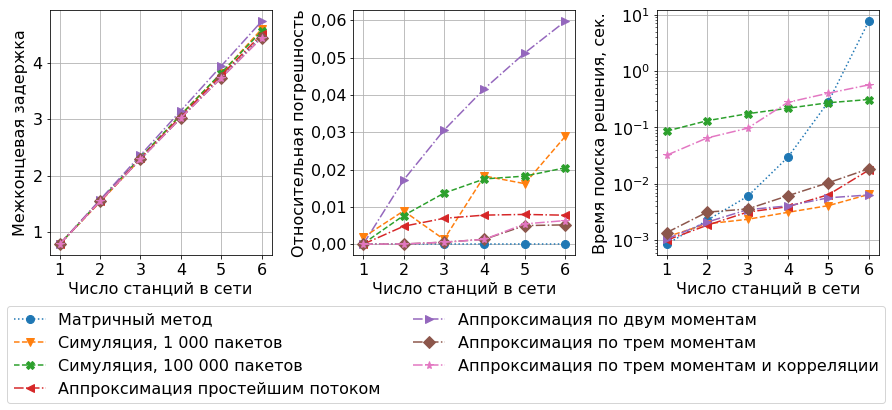

In [62]:
def plot_data(data, max_net_size, show_errors=True, file_name=None):
    OX = np.arange(1, max_net_size + 1)
    fig, axes = plt.subplots(1, 3 if show_errors else 2, figsize=(12.5, 4.5))
    
    ELAPSED_AX_INDEX = 2 if show_errors else 1

    precise_delays = np.asarray([item[0] for item in data['precise']])

    for key in data.keys():
        delays = [item[0] for item in data[key]]
        elapsed = [item[2] for item in data[key]]

        kws = STYLES[key]

        axes[0].plot(OX[:len(delays)], delays, **kws)
        if show_errors:
            num_ticks = min(len(precise_delays), len(delays))
            errors = np.abs(np.asarray(delays[:num_ticks]) - precise_delays[:num_ticks]) / precise_delays[:num_ticks]
            axes[1].plot(OX[:num_ticks], errors, **kws)
        
        axes[ELAPSED_AX_INDEX].plot(OX[:len(elapsed)], elapsed, **kws)

    axes[0].set_ylabel('Межконцевая задержка')
    if show_errors:
        axes[1].set_ylabel('Относительная погрешность')
    axes[ELAPSED_AX_INDEX].set_ylabel('Время поиска решения, сек.')
    axes[ELAPSED_AX_INDEX].set_yscale('log')
#     axes[2].set_ylim((0.001, 20))

    axes[0].set_xticks(OX)
    axes[ELAPSED_AX_INDEX].set_xticks(OX)
    if len(precise_delays) == len(OX):
        axes[1].set_xticks(OX)

    for i, ax in enumerate(axes):
        ax.grid()
        
        ax.set_xlabel('Число станций в сети')

    fig.legend(*axes[0].get_legend_handles_labels(), 
               loc='lower center', bbox_to_anchor=(0.5, -0.30), ncol=2)

    plt.tight_layout()
    if file_name is not None:
        fig.savefig(os.path.join("images", file_name), bbox_inches="tight")

plot_data(BASIC_DATA, BASIC_INP['max_net_size'], file_name='olga_mm1n.pdf')

На графиках показаны зависимости межконцевых задержек от числа станций в сети, время, затраченное на поиск решения, а также относительная ошибка оценки (в предположении, что матричный метод дает точную оценку). Можно видеть, что за исключением аппроксимации выходных потоков по двум моментам, вычисления методом симуляции и аппроксимации выходных потоков позволяют получить оценки с точностью свыше 97%. Отметим, что для рассматриваемого случая учет корреляции не дает повышения точности, а также, что вычисление методом аппроксимации выходящих потоков позволяет получить немного более точный результат по сравнению с симуляцией.


Время вычисления с помощью матричного метода растет экспоненциально, как и размерность выходящих потоков. Для систем малого размера вычисление матричным методом оказывается быстрее симуляции, однако уже для сетей с $N = 5$ станциями симуляция работает быстрее. Время, требуемое для выполнения симуляции, пропорционально числу моделируемых пакетов, и зависит почти линейно от числа станций в сети. Время, необходимое для решения методом аппроксимации выходящих потоков, оказывается даже меньшим, чем требуется для выполнения симуляции 100'000 пакетов, и также зависит линейно от длины сети. Однако, в более общем случае метод аппроксимации выходящих потоков может требовать существенно больше времени из-за необходимости вычисления решений систем линейных алгебраических уравнений с матрицами, полученными из генераторов выходящих потоков, размерность которых может меняться от станции к станции в зависимости от размерности аппроксимированного потока.

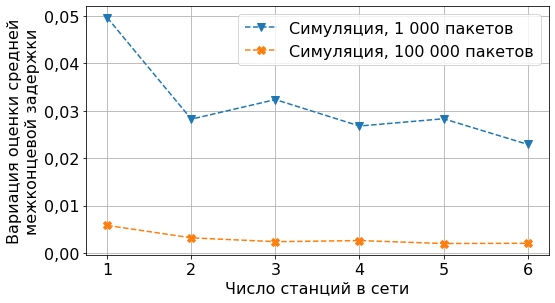

In [70]:
def plot_sim_var(data, max_net_size, file_name=None):
    OX = np.arange(1, max_net_size + 1)
    fig, ax = plt.subplots(1, 1, figsize=(8, 4.5))

    ax.plot(OX, [item[1] for item in data['sim_rough']], **STYLES['sim_rough'])
    ax.plot(OX, [item[1] for item in data['sim_fine']], **STYLES['sim_fine'])
    ax.grid()
    
    ax.set_xlabel('Число станций в сети')
    ax.set_ylabel('Вариация оценки средней\nмежконцевой задержки')
    ax.legend()
    plt.tight_layout()
    
    if file_name is not None:
        fig.savefig(os.path.join("images", file_name), bbox_inches="tight")
    

plot_sim_var(BASIC_DATA, BASIC_INP['max_net_size'], file_name='olga_mm1n_var.pdf')

Хотя точность усредненных оценок межконцевых задержек, полученных с помощью симуляции, для исследуемой сети не сильно зависит от числа моделируемых заявок, в общем случае желательно моделировать как можно больше пакетов. Причина этого - существенная вариация оценок, полученных при однократном выполнении симуляции малого числа заявок, показанная на рисунке 2. То есть, при однократном выполнении имитационной модели с 1000 пакетов можно получить оценку с ошибкой вплоть до 5-7%. В то же время, при моделировании 100'000 пакетов, средние оценки практически не меняются от итерации к итерации. Отметим, что число пакетов, которые нужно промоделировать для получения статистически устойчивых оценок, зависит от конкретных входящих потоков и распределений времени обслуживания.


## Расчет характеристик системы с произвольными распределениями

Пакет `pyqumo` позволяет вычислять оценки сетей массового обслуживания с входящими MAP-потоками и PH-распределениями с помощью матричного метода и имитационного моделирования. В качестве более общего примера рассмотрим сеть, в которой входящий $\text{MAP}(D_0, D_1)$:

$$
D_0 = \begin{pmatrix}
-1 & 0.4 & 0\\
1 & -1 & 0\\
0,2 & 0 & -200
\end{pmatrix}\qquad
D_1 = \begin{pmatrix}
0,58 & 0 & 0,02\\
0 & 0 & 0\\
0 & 0 & 199.8
\end{pmatrix},
$$

а в качестве PH-распределения $\text{PH}(S, \vec{p})$ используется гиперэрланговское распредеделение:

$$
S = \begin{pmatrix}
-100 &  100 &   0   &  0    &    0  &   0   \\
  0  & -100 &  100  &  0    &    0  &   0   \\
  0  &   0  & -100  &  0    &    0  &   0   \\
  0  &   0  &   0   & -10^5 &  10^5 &   0   \\
  0  &   0  &   0   &  0    & -10^5 &  10^5 \\
  0  &   0  &   0   &  0    &    0  & -10^5
\end{pmatrix}\qquad
\vec{p}^T = \begin{pmatrix}
0,9 \\
0   \\
0   \\
0,1 \\
0   \\
0
\end{pmatrix}
$$.

Емкость очереди будем полагать равной $K = 2$. 

Рассматриваемый MAP-поток имеет среднюю интенсивность $\lambda \approx 13,72$, коэффициент вариации $c_a \approx 8,13$ и коэффициент корреляции (с лагом 1) $\rho_1 \approx 0,422$. Интенсивность обслуживания $\mu \approx 37,033$, коэффициент вариации длительности обслуживания $c_s \approx 0,694$.

Размерность выходящего потока с первого узла моделируемой сети равна $72 = 3 \bullet 6 \bullet (2 + 2)$. Выходящий поток со второго узла уже будет иметь $1728$ состояний, а с третьего - $41'472$ состояний. Из-за столь быстрого роста размерности задачи ограничим применение матричного метода сетью длины $N = 2$. С помощью симуляции и аппроксимации выходящих потоков найдем оценки межконцевых задержек для сетей большего размера, вплоть до $N_{max} = 10$.

In [64]:
S = np.asarray([
    [-100, 100, 0, 0, 0, 0],
    [0, -100, 100, 0, 0, 0],
    [0, 0, -100, 0, 0, 0],
    [0, 0, 0, -100_000, 100_000, 0],
    [0, 0, 0, 0, -100_000, 100_000],
    [0, 0, 0, 0, 0, -100_000]
])
p = np.asarray([0.9, 0, 0, 0.1, 0, 0])

PH = PhaseType(S, p)
print(f"Mean: {PH.mean:.3f}\n"
      f"Std : {PH.std:.3f}\n"
      f"CV  : {PH.cv:.3f}\n"
      f"Rate: {PH.rate:.3f}")
print("S:")
print_matrix(S)
print("tau:")
print_matrix(p.reshape((1, len(p))))

Mean: 0.027
Std : 0.019
CV  : 0.694
Rate: 37.033
S:


<IPython.core.display.Math object>

tau:


<IPython.core.display.Math object>

In [65]:
D0 = np.asarray([
    [-1, 0.4, 0],
    [1, -1, 0],
    [0.2, 0, -200]
])
D1 = np.asarray([
    [0.58, 0, 0.02],
    [0, 0, 0],
    [0, 0, 199.8]
])

MAP = MarkovArrival(D0, D1)
print(f"Mean: {MAP.mean:.3f}\n"
      f"Std : {MAP.std:.3f}\n"
      f"CV  : {MAP.cv:.3f}\n"
      f"Rate: {MAP.rate:.3f}\n"
      f"Corr: {MAP.lag(1)}")

print("D0:")
print_matrix(D0)

print("D1:")
print_matrix(D1)

Mean: 0.073
Std : 0.593
CV  : 8.130
Rate: 13.720
Corr: 0.42208306174254717
D0:


<IPython.core.display.Math object>

D1:


<IPython.core.display.Math object>

In [66]:
CAPACITY = 2

# RUN EXPERIMENT:
COMPLEX_DATA = compute_results(
    arrival=MAP,
    service=PH,
    capacity=CAPACITY,
    max_net_size=10,
    max_precise_net_size=2,
)

  0%|          | 0/10 [00:00<?, ?it/s]

In [67]:
COMPLEX_DATA['precise']

[(0.06866484045420226, 2.0210908109617753e-16, 0.012321078777313232),
 (0.11594086850479106, 2.393942358166996e-16, 1.9347410559654237)]

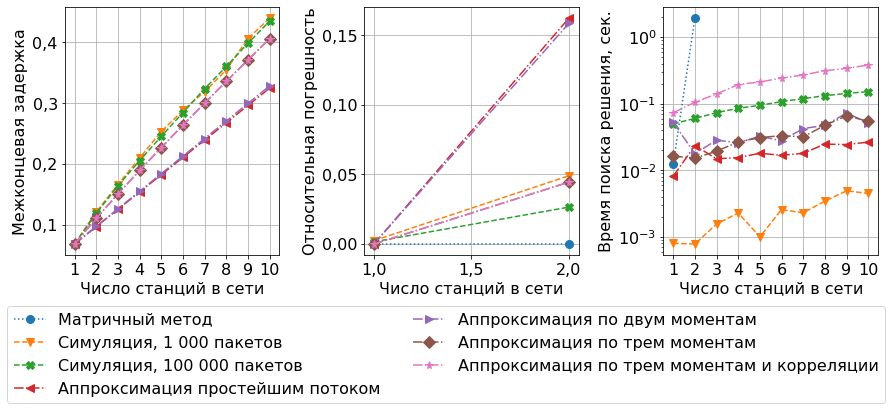

In [69]:
plot_data(COMPLEX_DATA, 10, show_errors=True, file_name="olga_mapph1n.pdf")

Как и ранее для простой модели с пуассоновским потоком, на рис.3 показаны зависимости межконцевой задержки от числа станций, время, которое требовалось для поиска решения и относительная ошибка, рассчитанные матричным методом, имитационным моделированием с 1'000 и 100'000 пакетами и методом аппроксимации выходящих потоков. С помощью матричного метода решение удалось найти только для сетей длины $N = 1, 2$, при дальнейшем увеличении числа станций размеры генераторов оказывались слишком большими. На выполнение расчета матричным методом для сети длины $N = 1$ потребовалось $0,11$ сек., а для сети длины $N = 2$ потребовалось $1,9$ сек.

В отличие от простейшего примера, рассмотренного ранее, здесь наиболее точную оценку дает имитационное моделирование, причем точность уже существенно зависит от числа моделируемых пакетов (97,5% для $N = 2$ узлов при моделировании 100'000 пакетов против 95% при моделировании 1'000 пакетов). Аппроксимация выходящих потоков по одном или двум моментам дает очень высокую погрешность (точность для $N = 2$ станций приблизительно равна 84%), а аппроксимация выходящего потока по трем моментам (как с учетом, так и без учета корреляции) дает точность немного выше, чем имитационное моделирование 1'000 пакетов, при этом требуя значительно больше времени.

Таким образом, для получения наиболее точных оценок в общем случае рекомендуется использовать имитационную модель, в которой моделируется достаточно большое количество пакетов. Если же требуется иметь возможность вычислять оценки сети аналитически, можно использовать метод аппроксимации выходящих потоков методом моментов по среднему, вариации и асимметрии; учет коэффициента корреляции может повысить точность, но не так существенно, как учет коэффициента асимметрии.